# simple demo for UNet

In [1]:
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# download dataset

In [219]:
## download and preparing data
def setup_seed(seed):
     torch.manual_seed(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(0)

BATCH_SIZE = 2048
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 下载训练集
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train = True,download=True,transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2)
    ])),
    batch_size = BATCH_SIZE, shuffle = True)


examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets[0:9])
print(example_data.shape)

tensor([6, 8, 8, 7, 8, 0, 0, 5, 6])
torch.Size([2048, 1, 32, 32])


# viz sample data

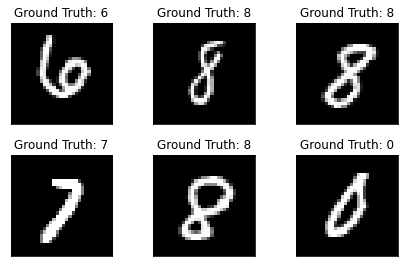

In [220]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# generate ground truth

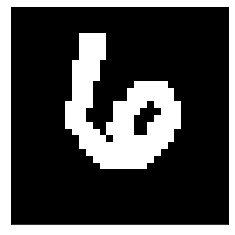

In [221]:
## viz generated data
tmp_data = example_data[0][0]
tmp_data[tmp_data>0]=1

fig = plt.figure()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

# generate fake data sample

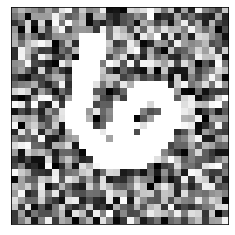

In [203]:
## viz generated data
tmp_data = example_data[0][0]
tmp_data[tmp_data>0]=1
tmp_data[tmp_data==0]= torch.FloatTensor(np.random.random(tmp_data.shape)[tmp_data==0])

fig = plt.figure()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

# function for fake data/label

In [185]:
## make fake data
def fake_data_label(img_mat):
    img_mat[img_mat>0] = 1
    ## generate label
    label = img_mat
    ## generate data
    fill = img_mat==0
    img_mat[fill] = torch.FloatTensor(np.random.random(img_mat.shape)[fill])
            
    return img_mat,label
    

data_set,tag_set = fake_data_label(example_data[0][0])
data_set = data_set.reshape(1,data_set.shape[0],data_set.shape[1])
tag_set = tag_set.reshape(1,tag_set.shape[0],tag_set.shape[1])

# convert all data/label

In [186]:
for i in range(BATCH_SIZE):
    if i==0:
        continue
    tmp_data,tmp_tag = fake_data_label(example_data[i][0])
    tmp_data = tmp_data.reshape(1,tmp_data.shape[0],tmp_data.shape[1])
    tmp_tag = tmp_tag.reshape(1,tmp_tag.shape[0],tmp_tag.shape[1])
    data_set = np.concatenate((data_set,tmp_data))
    tag_set = np.concatenate((tag_set,tmp_tag))
    
print(data_set.shape)
print(tag_set.shape)

(2048, 32, 32)
(2048, 32, 32)


# build the dataset and dataloader

In [188]:
from torch.utils.data import Dataset, DataLoader

class Cstd_Data(Dataset):
    def __init__(self, data_set, tag_set):
        self.img_ndarray = data_set
        self.tag_set = tag_set
        self.len = len(self.tag_set)
 
    def __getitem__(self, i):
        img = self.img_ndarray[i]
        label=np.array(self.tag_set[i])
        return img, label
 
    def __len__(self):
        data_len = len(self.tag_set)
        return data_len
    
train_data = Cstd_Data(data_set, tag_set)

# make NN

In [ ]:
32*32 -- 32*32 -- 32*32                                                                                32*32 -- 32*32 -- 32*32
                     |                                                                                   |
                    16*16 -- 16*16 -- 16*16                                         16*16 -- 16*16 -- 16*16
                                          |                                           |    
                                         8*8 -- 8*8 -- 8*8             8*8 -- 8*8 -- 8*8
                                                        |               |        
                                                       4*4 -- 4*4 -- 4*4

In [194]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.part_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.max_pool_1 = nn.MaxPool2d(2)
        self.part_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.max_pool_2 = nn.MaxPool2d(2)
        self.part_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.max_pool_3 = nn.MaxPool2d(2)
        self.part_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.upconv_1 = nn.UpsamplingBilinear2d(8)
        self.part_5 = nn.Sequential(
            nn.Conv2d(384, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.upconv_2 = nn.UpsamplingBilinear2d(16)
        self.part_6 = nn.Sequential(
            nn.Conv2d(192, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.upconv_3 = nn.UpsamplingBilinear2d(32)
        self.part_7 = nn.Sequential(
            nn.Conv2d(96, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32,1,1)
        )

    def forward(self, x):
        x_1 = self.part_1(x)                  ## 32*32
        x_2 = self.max_pool_1(x_1)
        x_2 = self.part_2(x_2)                ## 16*16
        x_3 = self.max_pool_2(x_2)
        x_3 = self.part_3(x_3)                ## 8*8
        x_4 = self.max_pool_3(x_3)
        x_4 = self.part_4(x_4)
        x_4 = self.upconv_1(x_4)
        x_4 = torch.cat([x_4,x_3],dim=1)
        x_4 = self.part_5(x_4)
        x_4 = self.upconv_2(x_4)
        x_4 = torch.cat([x_4,x_2],dim=1)
        x_4 = self.part_6(x_4)
        x_4 = self.upconv_3(x_4)
        x_4 = torch.cat([x_4,x_1],dim=1)
        x_4 = self.part_7(x_4)
        output = torch.sigmoid(x_4)
        return output

model = UNet().to(DEVICE)

# train model

In [192]:
model.train()
B_S = 32
Epoch = 10
num = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size = B_S, shuffle = True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()

for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [1568/2048 (77%)]	Loss: 0.021372
Train Epoch: 1 [1120/2048 (55%)]	Loss: 0.005887
Train Epoch: 2 [672/2048 (33%)]	Loss: 0.003030
Train Epoch: 3 [224/2048 (11%)]	Loss: 0.002255
Train Epoch: 3 [1824/2048 (89%)]	Loss: 0.001937
Train Epoch: 4 [1376/2048 (67%)]	Loss: 0.001782
Train Epoch: 5 [928/2048 (45%)]	Loss: 0.001671
Train Epoch: 6 [480/2048 (23%)]	Loss: 0.001632
Train Epoch: 7 [32/2048 (2%)]	Loss: 0.001540
Train Epoch: 7 [1632/2048 (80%)]	Loss: 0.001465
Train Epoch: 8 [1184/2048 (58%)]	Loss: 0.001495
Train Epoch: 9 [736/2048 (36%)]	Loss: 0.001403


In [195]:
model.train()
B_S = 32
Epoch = 10
num = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size = B_S, shuffle = True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()

for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [608/2048 (30%)]	Loss: 0.060752
Train Epoch: 0 [1248/2048 (61%)]	Loss: 0.034073
Train Epoch: 0 [1888/2048 (92%)]	Loss: 0.019015
Train Epoch: 1 [480/2048 (23%)]	Loss: 0.012087
Train Epoch: 1 [1120/2048 (55%)]	Loss: 0.008962
Train Epoch: 1 [1760/2048 (86%)]	Loss: 0.007282
Train Epoch: 2 [352/2048 (17%)]	Loss: 0.006234
Train Epoch: 2 [992/2048 (48%)]	Loss: 0.005566
Train Epoch: 2 [1632/2048 (80%)]	Loss: 0.005075
Train Epoch: 3 [224/2048 (11%)]	Loss: 0.004672
Train Epoch: 3 [864/2048 (42%)]	Loss: 0.004507
Train Epoch: 3 [1504/2048 (73%)]	Loss: 0.004277
Train Epoch: 4 [96/2048 (5%)]	Loss: 0.004029
Train Epoch: 4 [736/2048 (36%)]	Loss: 0.003934
Train Epoch: 4 [1376/2048 (67%)]	Loss: 0.003793
Train Epoch: 4 [2016/2048 (98%)]	Loss: 0.003633
Train Epoch: 5 [608/2048 (30%)]	Loss: 0.003433
Train Epoch: 5 [1248/2048 (61%)]	Loss: 0.003397
Train Epoch: 5 [1888/2048 (92%)]	Loss: 0.003340
Train Epoch: 6 [480/2048 (23%)]	Loss: 0.003226
Train Epoch: 6 [1120/2048 (55%)]	Loss: 0.003150
Trai

In [190]:
model.train()
B_S = 32
Epoch = 10
num = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size = B_S, shuffle = True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()

for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [1568/2048 (77%)]	Loss: 0.446795
Train Epoch: 1 [1120/2048 (55%)]	Loss: 0.443944
Train Epoch: 2 [672/2048 (33%)]	Loss: 0.440784
Train Epoch: 3 [224/2048 (11%)]	Loss: 0.438881
Train Epoch: 3 [1824/2048 (89%)]	Loss: 0.436511
Train Epoch: 4 [1376/2048 (67%)]	Loss: 0.436172
Train Epoch: 5 [928/2048 (45%)]	Loss: 0.429495
Train Epoch: 6 [480/2048 (23%)]	Loss: 0.433925
Train Epoch: 7 [32/2048 (2%)]	Loss: 0.438826
Train Epoch: 7 [1632/2048 (80%)]	Loss: 0.430015
Train Epoch: 8 [1184/2048 (58%)]	Loss: 0.431148
Train Epoch: 9 [736/2048 (36%)]	Loss: 0.433322


In [191]:
model.train()
B_S = 32
Epoch = 10
num = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size = B_S, shuffle = True)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
model.train()

for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = F.binary_cross_entropy_with_logits(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [1568/2048 (77%)]	Loss: 0.587277
Train Epoch: 1 [1120/2048 (55%)]	Loss: 0.583778
Train Epoch: 2 [672/2048 (33%)]	Loss: 0.583515
Train Epoch: 3 [224/2048 (11%)]	Loss: 0.576826
Train Epoch: 3 [1824/2048 (89%)]	Loss: 0.578194
Train Epoch: 4 [1376/2048 (67%)]	Loss: 0.577626
Train Epoch: 5 [928/2048 (45%)]	Loss: 0.581325
Train Epoch: 6 [480/2048 (23%)]	Loss: 0.573601
Train Epoch: 7 [32/2048 (2%)]	Loss: 0.576068
Train Epoch: 7 [1632/2048 (80%)]	Loss: 0.575551
Train Epoch: 8 [1184/2048 (58%)]	Loss: 0.574247
Train Epoch: 9 [736/2048 (36%)]	Loss: 0.576284


In [190]:
for epoch in range(Epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float().to(DEVICE), target.unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        output = model(data.unsqueeze(1))
        loss = F.binary_cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        num = num + 1
        if num%50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Train Epoch: 0 [1568/2048 (77%)]	Loss: 0.446795
Train Epoch: 1 [1120/2048 (55%)]	Loss: 0.443944
Train Epoch: 2 [672/2048 (33%)]	Loss: 0.440784
Train Epoch: 3 [224/2048 (11%)]	Loss: 0.438881
Train Epoch: 3 [1824/2048 (89%)]	Loss: 0.436511
Train Epoch: 4 [1376/2048 (67%)]	Loss: 0.436172
Train Epoch: 5 [928/2048 (45%)]	Loss: 0.429495
Train Epoch: 6 [480/2048 (23%)]	Loss: 0.433925
Train Epoch: 7 [32/2048 (2%)]	Loss: 0.438826
Train Epoch: 7 [1632/2048 (80%)]	Loss: 0.430015
Train Epoch: 8 [1184/2048 (58%)]	Loss: 0.431148
Train Epoch: 9 [736/2048 (36%)]	Loss: 0.433322


# model evaluation

In [204]:
model.eval()

UNet(
  (part_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (part_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (max_pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

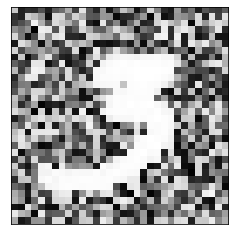

In [218]:
fig = plt.figure()
plt.imshow(output[2][0].detach().numpy(), 
           cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()